In [1]:
import pandas as pd
import re
import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import numpy as np
from typing import List
from nltk.tokenize import word_tokenize

In [2]:
def filter_stop_words(text: List[str])->List[str]:
    stop_words = set(stopwords.words("english"))
    return [word for word in text if word not in stop_words]


dialogues = pd.read_csv('../code/emo_context_train.txt', sep="\t")
#dialogues = dialogues[dialogues["label"]!="others"]
labels = dialogues.label
cols = ["turn1", "turn2", "turn3"]
dialogues["combined"] = dialogues[cols].apply(lambda row: ' '.join(row.values.astype(str)), axis=1)
dialogues["combined"] = dialogues["combined"].apply(str.lower).apply(word_tokenize).apply(filter_stop_words).apply(lambda x: " ".join(x))
#dialogues["combined"] = dialogues["combined"].apply(str.lower).apply(word_tokenize).apply(lambda x: " ".join(x))
dialogues["seq_len"] = dialogues["combined"].apply(len)
print(dialogues.columns)

max_len = dialogues["seq_len"].max()
input_text = dialogues.combined.values

Index(['id', 'turn1', 'turn2', 'turn3', 'label', 'combined', 'seq_len'], dtype='object')


In [3]:
# vectorise the utterances, start with term frequency 
from sklearn.feature_extraction.text import TfidfVectorizer


In [4]:
from sklearn import naive_bayes
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import math 
import sklearn
from sklearn import metrics

In [5]:
text_transformer = TfidfVectorizer(ngram_range=(1, 2), max_features=1000)
train_data, val_data, train_labels, val_labels = train_test_split(input_text, labels, test_size=0.2, random_state=42)
X_train_text = text_transformer.fit_transform(train_data)
X_test_text = text_transformer.transform(val_data)


nb = MultinomialNB()
nb.fit(X_train_text, train_labels)

MultinomialNB()

In [6]:
predictionsNB = nb.predict(X_test_text)
predict_probs = nb.predict_proba(X_test_text)

In [7]:
score = nb.score(X_test_text, val_labels)

print(score)
print("Accuracy score %.3f", sklearn.metrics.accuracy_score(val_labels, predictionsNB,))
print("f1 score", sklearn.metrics.f1_score(val_labels, predictionsNB, average='macro'))

0.7170092838196287
Accuracy score %.3f 0.7170092838196287
f1 score 0.6536015357063444


In [8]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

#labels = ['happy','sad','angry']
confusion_matrix = sklearn.metrics.confusion_matrix(val_labels, predictionsNB, labels=nb.classes_)
display(confusion_matrix)

array([[ 653,   12,  410,   47],
       [  18,  304,  464,   25],
       [  69,   64, 2768,   78],
       [  35,   17,  468,  600]])

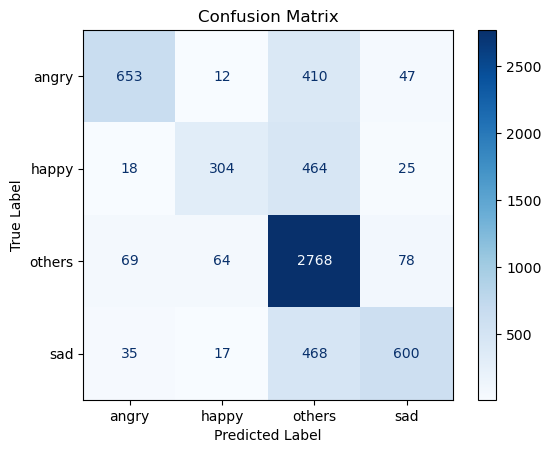

['angry' 'happy' 'others' 'sad']


In [9]:
color = 'black'

cm_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels=nb.classes_)
cm_display.plot(cmap=plt.cm.Blues)
cm_display.ax_.set_title('Confusion Matrix', color=color)
plt.xlabel('Predicted Label', color=color)
plt.ylabel('True Label', color=color)
plt.gcf().axes[0].tick_params(colors=color)
plt.gcf().axes[1].tick_params(colors=color)
plt.show()
print(nb.classes_)

In [10]:
from sklearn.metrics import classification_report
 
print(classification_report(val_labels, predictionsNB))

val_labels
predict_probs

              precision    recall  f1-score   support

       angry       0.84      0.58      0.69      1122
       happy       0.77      0.37      0.50       811
      others       0.67      0.93      0.78      2979
         sad       0.80      0.54      0.64      1120

    accuracy                           0.72      6032
   macro avg       0.77      0.61      0.65      6032
weighted avg       0.74      0.72      0.70      6032



array([[0.02518228, 0.72762902, 0.18893769, 0.05825101],
       [0.06123334, 0.09619336, 0.73997207, 0.10260122],
       [0.1438686 , 0.10853593, 0.51316454, 0.23443093],
       ...,
       [0.19005901, 0.09090446, 0.55088024, 0.16815629],
       [0.07119317, 0.13802135, 0.56445167, 0.22633381],
       [0.0794118 , 0.22965181, 0.64915913, 0.04177726]])